<h1>
    Qu-OPTICS Simuating quantum systems
</h1>

Using qutip in this notebook, we explore some of the possiblities of QuTiP and other tools in simulating open-quantum systems. These systems can be evaluated using the master equation solver <code>mesolve()</code> which requires the definition of just an intial state $\rho_0$ and a Hamiltonian $H$. The master equation is given below.

<h3>
    $$ \dot\rho(t)  = -\frac{i}{\hbar} \left[H(t),\rho(t)\right] + \sum_n \frac{1}{2}\left[2 C_n \rho(t) C_n^{\dagger}-\rho(t) C_n^{\dagger} C_n-C_n^{\dagger} C_n \rho(t)\right] $$
    $$
    \begin{aligned}
        & C_1=\sqrt{\kappa(1+\langle n\rangle)} a \\
        & C_2=\sqrt{\kappa\langle n\rangle} a^{\dagger}
    \end{aligned}
    $$
    <h3>
        <br>
        $$ H = \underbrace{a^{\dagger} a}_{\mathrm{H-O}}  + \underbrace{\Omega (a^{\dagger} +a)}_{\mathrm{Driving}} + \underbrace{\kappa(a^{\dagger}aa^{\dagger}a)}_{\mathrm{Kerr~non-linearity}} $$
    </h2>
</h2>

<IPython.core.display.Javascript object>


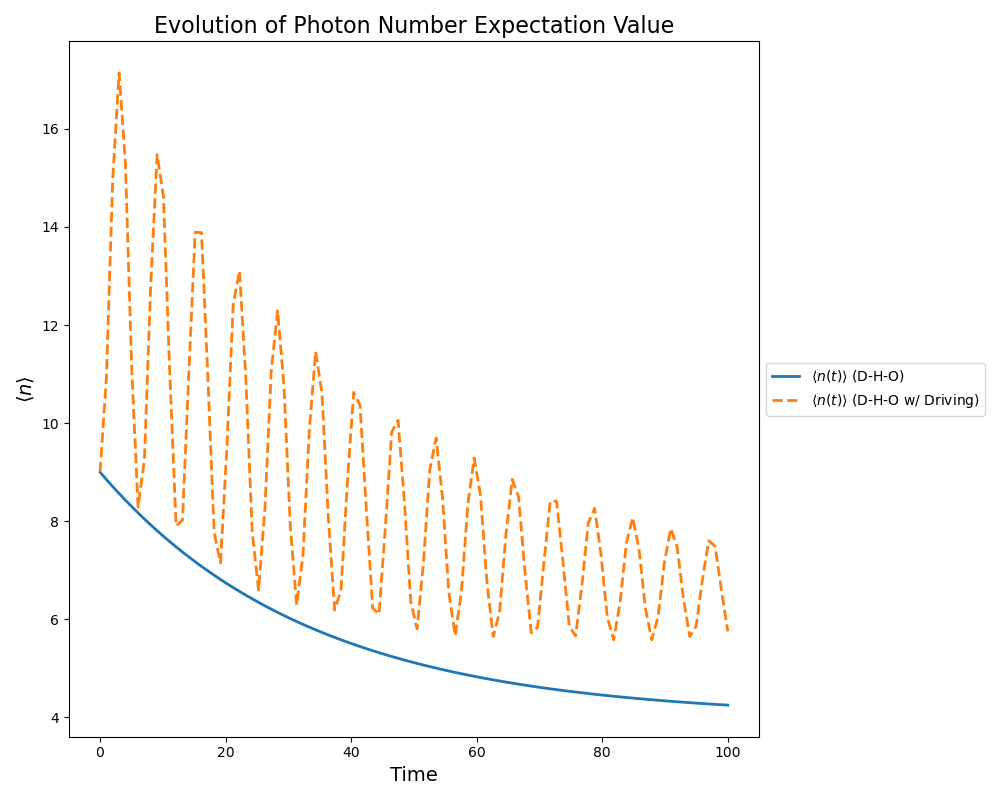

In [6]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from ipywidgets import interactive, FloatSlider, IntSlider, Checkbox, VBox, HBox, Button, Output, HTML
from IPython.display import display

# Initialize the figure outside the simulation function
fig, ax = plt.subplots(figsize=(10, 8), layout='tight')

# Add individual checkboxes for controlling transparency for each plot
base_alpha_checkbox = Checkbox(value=False, description="Hide D-H-O")
driving_alpha_checkbox = Checkbox(value=False, description="Hide driving")
kerr_alpha_checkbox = Checkbox(value=False, description="Hide Kerr")

# Add a loading label
loading_label = HTML("<h3 style='color: blue;'>Loading...</h3>")
loading_label.layout.display = 'none'  # Initially hidden

# Create sliders
N_slider = IntSlider(value=30, min=1, max=100, description='N:')
n_th_a_slider = FloatSlider(value=4, min=0, max=10, step=0.1, description='n_th_a:')
psi0_val_slider = IntSlider(value=9, min=0, max=30, description='psi0_val:')
kappa_slider = FloatSlider(value=0.03, min=0.0, max=1.0, step=0.01, description='kappa:')
Omega_slider = FloatSlider(value=0.0, min=0.0, max=5.0, step=0.1, description='Omega:')
k_slider = FloatSlider(value=0.0, min=0.0, max=5.0, step=0.1, description='k:')

# Create checkboxes for driving and Kerr effects
driving_checkbox = Checkbox(value=False, description="Include Driving")
kerr_checkbox = Checkbox(value=False, description="Include Kerr")

# Create the submit button
submit_button = Button(description='Run Simulation')

# Function to simulate and update plot
def simulate_on_submit(N=30, n_th_a=4, psi0_val=9, kappa=0.03, driving=False, kerr=False, Omega=0.0, k=0.0, base_alpha=False, driving_alpha=False, kerr_alpha=False):
    ax.clear()  # Clear the previous plot
    
    a = destroy(N)
    
    # Base Hamiltonian
    H0 = a.dag() * a
    psi0 = basis(N, psi0_val)

    # Collapse operators
    c_op_list = []
    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * a)  # Decay operators
    rate = kappa * n_th_a
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * a.dag())  # Excitation operators

    # Set alpha values based on checkboxes
    base_alpha = 0.3 if base_alpha_checkbox.value else 1.0
    driving_alpha = 0.3 if driving_alpha_checkbox.value else 1.0
    kerr_alpha = 0.3 if kerr_alpha_checkbox.value else 1.0
    
    # Simulate for base Hamiltonian (H0)
    tlist = np.linspace(0, 100, 100)  # Shorter time range for faster updates
    opts = {'store_states': False}
    medata_base = mesolve(H0, psi0, tlist, c_op_list, [a.dag() * a], options=opts)
    
    # Plot for base Hamiltonian
    ax.plot(tlist, medata_base.expect[0], lw=2, label=r'$\langle n(t) \rangle$ (D-H-O)', alpha=base_alpha)
    
    # If driving is enabled, add the driving term and simulate
    if driving:
        H1 = Omega * (a.dag() + a)
        H_with_driving = H0 + H1
        medata_driving = mesolve(H_with_driving, psi0, tlist, c_op_list, [a.dag() * a], options=opts)
        ax.plot(tlist, medata_driving.expect[0], lw=2, linestyle='--', label=r'$\langle n(t) \rangle$ (D-H-O w/ Driving)', alpha=driving_alpha)
    
    # If Kerr nonlinearity is enabled, add the Kerr term and simulate
    if kerr:
        H2 = k * (a.dag() * a * a.dag() * a)
        H_with_kerr = H0 + (H1 if driving else 0) + H2
        medata_kerr = mesolve(H_with_kerr, psi0, tlist, c_op_list, [a.dag() * a], options=opts)
        ax.plot(tlist, medata_kerr.expect[0], lw=2, linestyle=':', label=r'$\langle n(t) \rangle$ (D-D-H-O w/Kerr)', alpha=kerr_alpha)
    
    # Set up the plot
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(r'$\langle n \rangle$', fontsize=14)
    ax.set_title('Evolution of Photon Number Expectation Value', fontsize=16)
    
    # Move the legend to the right side
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Redraw the updated plot
    plt.draw()

# Function to be called when the button is clicked
def on_submit(b):
    submit_button.disabled = True  # Disable the submit button
    loading_label.layout.display = 'block'  # Show loading label
    simulate_on_submit(N_slider.value, n_th_a_slider.value, psi0_val_slider.value, 
                       kappa_slider.value, driving_checkbox.value, kerr_checkbox.value, 
                       Omega_slider.value, k_slider.value, 
                       base_alpha_checkbox.value, driving_alpha_checkbox.value, kerr_alpha_checkbox.value)
    loading_label.layout.display = 'none'  # Hide loading label
    submit_button.disabled = False  # Re-enable the submit button

# Attach the function to the button
submit_button.on_click(on_submit)

# Arrange widgets in a box, include the transparency checkboxes
controls_box = VBox([N_slider, n_th_a_slider, psi0_val_slider, kappa_slider, 
                     HBox([driving_checkbox, Omega_slider]), 
                     HBox([kerr_checkbox, k_slider]), 
                     base_alpha_checkbox, driving_alpha_checkbox, kerr_alpha_checkbox, 
                     submit_button, loading_label])  # Include the loading label in controls

# Display controls
display(controls_box)

# Call the simulation function once to show the initial plot
simulate_on_submit(N_slider.value, n_th_a_slider.value, psi0_val_slider.value, 
                   kappa_slider.value, driving_checkbox.value, kerr_checkbox.value, 
                   Omega_slider.value, k_slider.value, 
                   base_alpha_checkbox.value, driving_alpha_checkbox.value, kerr_alpha_checkbox.value)
